### Install Model Trust Repository

In [1]:
import os

if not os.path.exists("trustyai-model-trust"):
    !git clone https://github.com/trustyai-explainability/trustyai-model-trust

In [2]:
!pip install trustyai-model-trust/

Processing ./trustyai-model-trust
  Preparing metadata (setup.py) ... done
  Created wheel for model-trust: filename=model_trust-0.0.1-py3-none-any.whl size=27955 sha256=bebdf18801ac367b90c06fa60e59b782d3bfe1d312e6744ab3548d428ffd0a52
  Stored in directory: /tmp/pip-ephem-wheel-cache-4dvuxn6o/wheels/70/c7/e0/ac890070dac83e6b26e3089662857ce01b09ae4cad2bd505d6
Successfully built model-trust
  Attempting uninstall: model-trust
    Found existing installation: model-trust 0.0.1
    Uninstalling model-trust-0.0.1:
      Successfully uninstalled model-trust-0.0.1

[notice] A new release of pip available: 22.2.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


### Imports

In [3]:
import json
import onnx
import warnings
import numpy as np
import pandas as pd
from joblib import dump
import onnxruntime as rt
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from model_trust.datasets.synthetic_data import load_linear_2_region_data
from model_trust.regression.region_uncertainty_estimation import RegionUncertaintyEstimator

warnings.filterwarnings("ignore")

### Load Data

In [4]:
quantile = 0.9
dataset = load_linear_2_region_data(nsamples=3000,
                                      quantile=quantile,
                                      sigma_0=1,
                                      sigma_1=4,
                                      test_ratio=0.2,
                                      cal_ratio=0.2,
                                      seed=42,)

data = dataset["data"]
features = dataset["features"]
target = dataset["target"]
X = data[features].values
Y = data[target].values

x_train = dataset["x_train"]
x_test = dataset["x_test"]
x_cal = dataset["x_cal"]

y_train = dataset["y_train"]
y_test = dataset["y_test"]
y_cal = dataset["y_cal"]

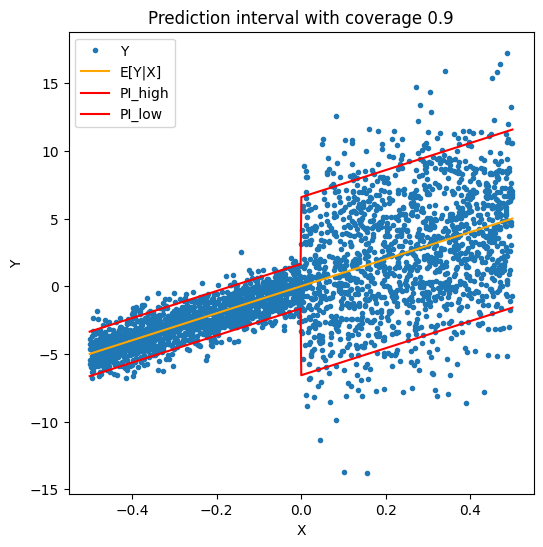

In [5]:
pi_gt_low = data["PI_GT_LOW"].values
pi_gt_high = data["PI_GT_HIGH"].values
Y_mean = data["Y_mean"].values
coverage_empirical = np.mean((Y <= pi_gt_high)& (Y >= pi_gt_low))

X_sort = np.sort(X.flatten())
X_sort_indices = np.argsort(X.flatten())

plt.figure(figsize=(6,6))
plt.plot(X, Y, ".", label="Y")
# plt.title("COVERAGE TARGET {}; EMPIRICAL : {}".format(str(quantile), str(np.round(coverage_empirical,2)))) # title ??
plt.title("Prediction interval with coverage {}".format(str(quantile)))

plt.plot(X_sort, Y_mean[X_sort_indices],  'orange', label = 'E[Y|X]')
plt.plot(X_sort, pi_gt_high[X_sort_indices], 'r', label = 'PI_high')
plt.plot(X_sort, pi_gt_low[X_sort_indices], 'r', label = 'PI_low')
plt.xlabel("X")
plt.ylabel("Y")

plt.legend()
plt.show()

### Download Base Model From S3

In [6]:
# s3 connection
import os
import boto3

session = boto3.Session(
    aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
    aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
)
s3_client = session.client('s3',
                    endpoint_url=os.getenv("AWS_ENDPOINT_URL"),
                    region_name=os.getenv("AWS_REGION"),
)



In [7]:
base_model_bucket = "model-trust" # s3 bucket with base model
base_model_path = "onnx_models/base_onnx_model.onnx" # model path within the s3 bucket

base_onnx_model_str = s3_client.get_object(Bucket=base_model_bucket, Key=base_model_path)['Body'].read()
base_onnx_model_str

b'\x08\x08\x12\x08skl2onnx\x1a\x061.15.0"\x07ai.onnx(\x002\x00:\xb0\x01\ni\n\x01X\x12\x08variable\x1a\x0fLinearRegressor"\x0fLinearRegressor*\x16\n\x0ccoefficients=\xbcC!A\xa0\x01\x06*\x14\n\nintercepts=\x1e\xec\xdc<\xa0\x01\x06:\nai.onnx.ml\x12\x16ONNX(LinearRegression)Z\x11\n\x01X\x12\x0c\n\n\x08\x01\x12\x06\n\x00\n\x02\x08\x01b\x18\n\x08variable\x12\x0c\n\n\x08\x01\x12\x06\n\x00\n\x02\x08\x01B\x0e\n\nai.onnx.ml\x10\x01B\x04\n\x00\x10\x11'

In [8]:
sess = rt.InferenceSession(base_onnx_model_str)
sess.run(None, {"X": x_test[0:1].astype(np.float32)})[0]

array([[2.4208233]], dtype=float32)

In [9]:
# y_pred_cal = base_model.predict(x_cal)
y_pred_cal = sess.run(None, {"X": x_cal.astype(np.float32)})[0].flatten()

### Train and Prepare Model Trust Model

In [10]:
multi_region_cp_inputs = {}
multi_region_cp_inputs['confidence'] = quantile*100
multi_region_cp_inputs['regions_model'] = "multi_region"
multi_region_cp_inputs['base_model'] = base_onnx_model_str

# region parameters
multi_region_cp_inputs["multi_region_model_selection_metric"] = "coverage_ratio"
multi_region_cp_inputs["multi_region_model_selection_stat"] = "min"
multi_region_cp_inputs["multi_region_min_group_size"] = 20

multi_region_cp_model = RegionUncertaintyEstimator(**multi_region_cp_inputs)

In [11]:
%time multi_region_cp_model.fit(x_cal, y_cal, y_pred_cal)

Best Params :{'min_samples_leaf': 50, 'ccp_alpha': 0.001, 'max_depth': 2, 'random_state': 42}
Best model :DecisionTreeRegressor(ccp_alpha=0.001, max_depth=2, min_samples_leaf=50,
                      random_state=42)
CPU times: user 3min 24s, sys: 972 ms, total: 3min 25s
Wall time: 1min 43s


### Upload Model Trust Model To COS

In [12]:
model_trust_wrapped_model = multi_region_cp_model.export_learned_config()['combined_model']
model_trust_wrapped_model

b'\x08\x08\x12\x19onnx.compose.merge_models\x1a\x031.0"\x00(\x01:\x80\x0f\nt\n\x01X\x12\x13base_model_variable\x1a\x0fLinearRegressor"\x0fLinearRegressor*\x16\n\x0ccoefficients=\xbcC!A\xa0\x01\x06*\x14\n\nintercepts=\x1e\xec\xdc<\xa0\x01\x06:\nai.onnx.ml\n\x15\n\x01X\x12\x06x_orig"\x08Identity\n\xcd\x04\n\x01X\x12\x08variable\x1a\x15TreeEnsembleRegressor"\x15TreeEnsembleRegressor*\x10\n\tn_targets\x18\x01\xa0\x01\x02*!\n\x12nodes_falsenodeids@\x02@\x00@\x04@\x00@\x00\xa0\x01\x07*\x1f\n\x10nodes_featureids@\x00@\x00@\x00@\x00@\x00\xa0\x01\x07*,\n\x0enodes_hitrates=\x00\x00\x80?=\x00\x00\x80?=\x00\x00\x80?=\x00\x00\x80?=\x00\x00\x80?\xa0\x01\x06*.\n\x1fnodes_missing_value_tracks_true@\x00@\x00@\x00@\x00@\x00\xa0\x01\x07*:\n\x0bnodes_modesJ\nBRANCH_LEQJ\x04LEAFJ\nBRANCH_LEQJ\x04LEAFJ\x04LEAF\xa0\x01\x08*\x1c\n\rnodes_nodeids@\x00@\x01@\x02@\x03@\x04\xa0\x01\x07*\x1c\n\rnodes_treeids@\x00@\x00@\x00@\x00@\x00\xa0\x01\x07* \n\x11nodes_truenodeids@\x01@\x00@\x03@\x00@\x00\xa0\x01\x07**\n\x0cn

In [13]:
# upload Model Trust model to S3
model_trust_wrapped_model_path = "onnx_models/multi_region_model_trust_model.onnx"
s3_client.put_object(Body=model_trust_wrapped_model, Bucket=base_model_bucket, Key=model_trust_wrapped_model_path)


{'ResponseMetadata': {'RequestId': '93a879c2-a6b9-48eb-bb8a-f0337e146a60',
  'HostId': '',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Wed, 13 Dec 2023 04:18:00 GMT',
   'x-clv-request-id': '93a879c2-a6b9-48eb-bb8a-f0337e146a60',
   'server': 'Cleversafe',
   'x-clv-s3-version': '2.5',
   'x-amz-request-id': '93a879c2-a6b9-48eb-bb8a-f0337e146a60',
   'etag': '"b1c8edf416bc8f5dbcc13f5a94ae81af"',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"b1c8edf416bc8f5dbcc13f5a94ae81af"'}

### Deploy Model Trust Wrapped Model From S3 on Model Mesh

By this time, you might have created a s3 data connection in ODH. If not, create a data connection following [ODH Docs](https://opendatahub.io/docs/getting-started-with-open-data-hub/). Then, obtain the data connection resource name by clicking on "?" next to data connection name. It would be similar to "aws-connection-s3store".

In [51]:
from kubernetes import client

from kserve import KServeClient
from kserve import constants
from kserve import V1beta1PredictorSpec, V1beta1Batcher
from kserve import V1beta1ModelSpec, V1beta1ModelFormat
from kserve import V1beta1StorageSpec
from kserve import V1beta1InferenceServiceSpec
from kserve import V1beta1InferenceService

service_name = "trust-single-region-cos-model-4"
project_name = "model-trust-ds-project"
s3_resource_name = "aws-connection-tsfmcos"

default_model_spec = V1beta1InferenceServiceSpec(predictor=V1beta1PredictorSpec(model=V1beta1ModelSpec(model_format=V1beta1ModelFormat(name="onnx"), 
                                                                                                       runtime="triton-2.x", 
                                                                                                      storage=V1beta1StorageSpec(key=s3_resource_name, path=model_trust_wrapped_model_path)),
                                                                               batcher=V1beta1Batcher(max_batch_size=10)))

isvc = V1beta1InferenceService(api_version=constants.KSERVE_V1BETA1,
                          kind=constants.KSERVE_KIND,
                          metadata=client.V1ObjectMeta(name=service_name, 
                                                       namespace=project_name, 
                                                       annotations={"serving.kserve.io/deploymentMode": "ModelMesh"}),
                          spec=default_model_spec)


kserve_client = KServeClient(config_file='./config')

# create inference service
kserve_client.create(isvc)
# isvc

{'apiVersion': 'serving.kserve.io/v1beta1',
 'kind': 'InferenceService',
 'metadata': {'annotations': {'serving.kserve.io/deploymentMode': 'ModelMesh'},
  'creationTimestamp': '2023-12-13T05:01:08Z',
  'generation': 1,
  'managedFields': [{'apiVersion': 'serving.kserve.io/v1beta1',
    'fieldsType': 'FieldsV1',
    'fieldsV1': {'f:metadata': {'f:annotations': {'.': {},
       'f:serving.kserve.io/deploymentMode': {}}},
     'f:spec': {'.': {},
      'f:predictor': {'.': {},
       'f:batcher': {'.': {}, 'f:maxBatchSize': {}},
       'f:model': {'.': {},
        'f:modelFormat': {'.': {}, 'f:name': {}},
        'f:name': {},
        'f:runtime': {},
        'f:storage': {'.': {}, 'f:key': {}, 'f:path': {}}}}}},
    'manager': 'OpenAPI-Generator',
    'operation': 'Update',
    'time': '2023-12-13T05:01:08Z'}],
  'name': 'trust-single-region-cos-model-4',
  'namespace': 'model-trust-ds-project',
  'resourceVersion': '37993612',
  'uid': '45dea48d-1af8-4db2-9a95-23f2f0daa745'},
 'spec': {

In [52]:
if not kserve_client.is_isvc_ready(service_name, namespace=project_name):
    kserve_client.wait_isvc_ready(name=service_name, namespace=project_name, timeout_seconds=5)

kserve_client.is_isvc_ready(service_name, namespace=project_name)

True

In [53]:
import openshift as oc

oc.set_default_kubeconfig_path("./config")

In [54]:
service_route = oc.selector("route.route.openshift.io/{}".format(service_name)).object(ignore_not_found=True)
if not service_route:
    print("Route is not created for the model. Deployment might have failed. Please check the deployment configuration again...")
    

In [55]:
service_route_dict = service_route.as_dict()
model_inference_path = "https://" + service_route_dict["spec"]["host"] + service_route_dict["spec"]["path"] + "/infer"
model_inference_path

'https://trust-single-region-cos-model-4-model-trust-ds-project.apps.odhnewcluster1.cp.fyre.ibm.com/v2/models/trust-single-region-cos-model-4/infer'

Test single instance

In [56]:
from model_trust.base.utils.data_utils import nparray_to_list

test_data = x_test[0:1]

req_data = {"inputs": [{
  "name" : "X",
  "shape" : list(test_data.shape),
  "datatype"  : "FP32",
  "data" : nparray_to_list(test_data)
    }]
}


In [57]:
import requests

requests.post(model_inference_path, json=req_data, verify=False).json()

{'model_name': 'trust-single-region-cos-model-4__isvc-a89b7cb37f',
 'model_version': '1',
 'outputs': [{'name': 'exp_lower_pred_endpoint',
   'datatype': 'FP32',
   'shape': [1, 1],
   'data': [-4.580826]},
  {'name': 'exp_upper_pred_endpoint',
   'datatype': 'FP32',
   'shape': [1, 1],
   'data': [9.422473]},
  {'name': 'input_x',
   'datatype': 'FP32',
   'shape': [1, 1],
   'data': [0.23750836]},
  {'name': 'prediction',
   'datatype': 'FP32',
   'shape': [1, 1],
   'data': [2.4208233]},
  {'name': 'region_model_prediction',
   'datatype': 'FP32',
   'shape': [1, 1],
   'data': [6.5734396]}]}

Test multiple instances

In [72]:
from model_trust.base.utils.data_utils import nparray_to_list

test_data = x_test[0:4]

req_data = {"inputs": [{
  "name" : "X",
  "shape" : list(test_data.shape),
  "datatype"  : "FP32",
  "data" : nparray_to_list(test_data)
    }]
}


In [73]:
import requests

requests.post(model_inference_path, json=req_data, verify=False).json()

{'model_name': 'trust-single-region-cos-model-4__isvc-a89b7cb37f',
 'model_version': '1',
 'outputs': [{'name': 'exp_lower_pred_endpoint',
   'datatype': 'FP32',
   'shape': [4, 1],
   'data': [-4.580826, -6.0722737, -4.2611713, -2.8696885]},
  {'name': 'exp_upper_pred_endpoint',
   'datatype': 'FP32',
   'shape': [4, 1],
   'data': [9.422473, -2.5951686, 9.742127, 0.6074163]},
  {'name': 'input_x',
   'datatype': 'FP32',
   'shape': [4, 1],
   'data': [0.23750836, -0.4326494, 0.26922315, -0.11490227]},
  {'name': 'prediction',
   'datatype': 'FP32',
   'shape': [4, 1],
   'data': [2.4208233, -4.333721, 2.740478, -1.1311362]},
  {'name': 'region_model_prediction',
   'datatype': 'FP32',
   'shape': [4, 1],
   'data': [6.5734396, 1.7398951, 6.5734396, 1.7398951]}]}

### Delete Model Deployment From Model Mesh

In [74]:
kserve_client.delete(service_name, namespace=project_name)

{'kind': 'Status',
 'apiVersion': 'v1',
 'metadata': {},
 'status': 'Success',
 'details': {'name': 'trust-single-region-cos-model-4',
  'group': 'serving.kserve.io',
  'kind': 'inferenceservices',
  'uid': '45dea48d-1af8-4db2-9a95-23f2f0daa745'}}

In [75]:
try:
    kserve_client.get(service_name, namespace=project_name)
except:
    print("Model deployment {} does not exist".format(service_name))

Model deployment trust-single-region-cos-model-4 does not exist
